<a href="https://colab.research.google.com/github/hsieh2000/HW/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ckiptagger
!pip install ckip_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.2 MB/s eta 0:00:00


In [15]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [6]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="bert-base", device=-1)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=-1)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=-1)
print("Initializing drivers ... all done")
print()

Initializing drivers ... WS
Initializing drivers ... POS


Initializing drivers ... NER


Initializing drivers ... all done



In [7]:
os.chdir("/content/drive/MyDrive/NLP")

In [8]:
ORIGINAL_DATA = pd.read_csv("data.csv")
ORIGINAL_DATA = ORIGINAL_DATA.drop(columns = ["Unnamed: 0"])
content = ORIGINAL_DATA["content"]


In [9]:
ORIGINAL_DATA

,article_title,content,message_count_all,message_count_boo,message_count_count,message_count_neutral,message_count_push
0,[狂幹] 孫運璿 vs 陳水扁,孫前院長和陳水扁的比較： 出身貧窮人家，苦讀完成學業，非經濟科班出身，任公職後，卻能為國拼出...,233,49,58,77,107
1,[無言] 國王的新衣,變調的童話：國王的新衣 他能在眾王子的爭奪戰中脫穎而出，除了自身的實力 其實也背負著全國極欲...,85,7,32,39,39
2,[吐嘈] =====沈老大在53台，婊DPP的4個影片片段=====,2006/05/17 民視新聞台 頭家來開講 婊DPP的4個clips 每一段都是切重要害的...,47,3,27,14,30
3,[大話] 笑話新聞 徐議員批馬片段,其實不只有徐議員啦 其他的人的講法 也大多都有入鏡 =================分格線...,21,1,11,8,12
4,[轉錄][囧rz]安西教練：「三井，你負責投外線！」,作者: mushishi (蟲師) 看板: joke 標題: [囧rz]安西教練：三井，你負...,150,3,134,10,137
...,...,...,...,...,...,...,...
79798,[討論] 這是第一次中央民調沒崩但地方大敗的局面嗎？,有長期看板上分享的民調就可以知道 不管總統或政院的滿意度 都沒像2006、2014或2018...,0,0,0,0,0
79799,[公告] 政治黑特板板規__20220803,第一章 總則 1.本板接受中華民國政府頒布之法律，教育部學術網路公約，以及PTT站方制定之...,0,0,0,0,0
79800,[公告] HatePolitic 發文門檻變更,選舉期間 發文門檻調到2000次 選舉過後視時機調回原次數 組務那邊也申請很久才設定好 也沒...,70,1,42,26,43
79801,[討論] 11月16日0時起不得再發布 評論相關民調,《公職人員選舉罷免法》第53條第2項規定，投票前10天起，也就是 11月16日0時起 ， 不...,39,0,13,26,13


In [10]:
# ws_results = ws_driver([content[0]])
# pos_results = pos_driver([content[0]])
# ner_results = ner_driver([content[0]])
# print(ws_results[0])
# print(pos_results[0])
# print(ner_results[0])



In [11]:
def read_stopword():
    with open("./stopwords_TW.txt", "r", encoding="utf-8") as f:
        stopword = [word.strip("\n") for word in f.readlines()]
    return stopword
stopwords = read_stopword()

def do_CKIP_WS(article):
  ws_results = ws_driver([article])
  return ws_results

def do_CKIP_POS(ws_result):
    # write your code in here
    pos = pos_driver(ws_result[0])
    all_list = []
    for sent in pos:

      all_list.append(sent)
    return all_list

def pos_filter(pos):
  for i in list(set(pos)):
    if i.startswith("N") or i.startswith("V"):
      return "Yes"
    else:
      continue

def cleaner(ws_results, pos_results, stopwords):
  word_lst = []
  for ws, pos in zip(ws_results[0], pos_results):
    in_stopwords_or_not = ws not in stopwords
    if_len_greater_than_1 = len(ws) > 1
    is_V_or_N = pos_filter(pos)
    if in_stopwords_or_not and if_len_greater_than_1 and is_V_or_N == "Yes":
      word_lst.append(ws)
    else:
      pass
  return word_lst


In [12]:
seg_lst = []
for i in range(0,100):
  ws_results = do_CKIP_WS(content[i])
  pos_results = do_CKIP_POS(ws_results)
  word_lst = cleaner(ws_results, pos_results, stopwords)
  seg_lst.append(word_lst)

Inference: 100%|██████████| 1/1 [00:15<00:00, 15.01s/it]


In [13]:
seg_lst

[['前院長',
  '陳水扁',
  '出身',
  '貧窮',
  '苦讀',
  '完成',
  '學業',
  '經濟',
  '科班',
  '出身',
  '公職',
  '拼出',
  '亮麗',
  '經濟',
  '成果',
  '出身',
  '貧窮',
  '苦讀',
  '完成',
  '學業',
  '經濟',
  '科班',
  '出身',
  '公職',
  '拼出',
  '亮麗',
  '經濟',
  '成果',
  '山東',
  '台灣',
  '台灣',
  '帶領',
  '台灣',
  '破敗',
  '走向',
  '繁榮',
  '台南',
  '台北',
  '台灣',
  '帶領',
  '台灣',
  '繁榮',
  '走向',
  '破敗',
  '傳記',
  '兒子',
  '當兵',
  '國防部長',
  '知道',
  '報導',
  '兒子',
  '當兵',
  '積架車',
  '上下班',
  '工商界',
  '解決',
  '經營',
  '問題',
  '工商界',
  '解決',
  '經濟',
  '問題',
  '瞭解',
  '事蹟',
  '心情',
  '感動',
  '飆淚',
  '瞭解',
  '事蹟',
  '心情',
  '激動',
  '開罵',
  '風範',
  '地方',
  '展現',
  '玷污',
  '先生'],
 ['變調',
  '童話',
  '國王',
  '新衣',
  '王子',
  '爭奪戰',
  '脫穎而出',
  '實力',
  '背負',
  '改變',
  '革新',
  '廉潔',
  '民眾',
  '期待',
  '加冕',
  '典禮',
  '慷慨',
  '激昂',
  '民眾',
  '演說',
  '擘畫',
  '施政',
  '藍圖',
  '大多數',
  '國人',
  '相信',
  '帶來',
  '希望',
  '帶來',
  '快樂',
  '帶來',
  '清廉',
  '帶來',
  '進步',
  '大學士',
  '皇位',
  '爭奪戰',
  '關鍵',
  '時點',
  '說出',
  '選擇',
  '沈淪',
  '提升',
  '大多數',
  '國人',
  '相信',


In [16]:
Y = Counter()
for i in seg_lst:
  X = Counter(i)
  Y+=X

In [17]:
Y

Counter({'前院長': 1,
         '陳水扁': 65,
         '出身': 6,
         '貧窮': 3,
         '苦讀': 2,
         '完成': 7,
         '學業': 2,
         '經濟': 29,
         '科班': 2,
         '公職': 2,
         '拼出': 2,
         '亮麗': 3,
         '成果': 3,
         '山東': 1,
         '台灣': 190,
         '帶領': 3,
         '破敗': 2,
         '走向': 7,
         '繁榮': 5,
         '台南': 9,
         '台北': 42,
         '傳記': 1,
         '兒子': 17,
         '當兵': 8,
         '國防部長': 1,
         '知道': 71,
         '報導': 14,
         '積架車': 1,
         '上下班': 1,
         '工商界': 2,
         '解決': 10,
         '經營': 7,
         '問題': 55,
         '瞭解': 3,
         '事蹟': 2,
         '心情': 5,
         '感動': 6,
         '飆淚': 1,
         '激動': 2,
         '開罵': 1,
         '風範': 4,
         '地方': 23,
         '展現': 4,
         '玷污': 1,
         '先生': 10,
         '變調': 1,
         '童話': 3,
         '國王': 8,
         '新衣': 4,
         '王子': 4,
         '爭奪戰': 3,
         '脫穎而出': 1,
         '實力': 1,
         '背負': 1,
      

In [89]:
ws_results = do_CKIP_WS(content[0])
pos_results = do_CKIP_POS(ws_results)

Inference: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


In [90]:
ans = cleaner(ws_results, pos_results, stopwords)

In [109]:
ans

['前院長',
 '陳水扁',
 '出身',
 '貧窮',
 '苦讀',
 '完成',
 '學業',
 '經濟',
 '科班',
 '出身',
 '公職',
 '拼出',
 '亮麗',
 '經濟',
 '成果',
 '出身',
 '貧窮',
 '苦讀',
 '完成',
 '學業',
 '經濟',
 '科班',
 '出身',
 '公職',
 '拼出',
 '亮麗',
 '經濟',
 '成果',
 '山東',
 '台灣',
 '台灣',
 '帶領',
 '台灣',
 '破敗',
 '走向',
 '繁榮',
 '台南',
 '台北',
 '台灣',
 '帶領',
 '台灣',
 '繁榮',
 '走向',
 '破敗',
 '傳記',
 '兒子',
 '當兵',
 '國防部長',
 '知道',
 '報導',
 '兒子',
 '當兵',
 '積架車',
 '上下班',
 '工商界',
 '解決',
 '經營',
 '問題',
 '工商界',
 '解決',
 '經濟',
 '問題',
 '瞭解',
 '事蹟',
 '心情',
 '感動',
 '飆淚',
 '瞭解',
 '事蹟',
 '心情',
 '激動',
 '開罵',
 '風範',
 '地方',
 '展現',
 '玷污',
 '先生']

In [92]:
ner_results = ner_driver([content[0]])
ner_results

Inference: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s]


[[NerToken(word='陳水扁', ner='PERSON', idx=(5, 8)),
  NerToken(word='山東', ner='GPE', idx=(96, 98)),
  NerToken(word='台灣', ner='GPE', idx=(99, 101)),
  NerToken(word='台灣', ner='GPE', idx=(105, 107)),
  NerToken(word='台灣', ner='GPE', idx=(110, 112)),
  NerToken(word='台南', ner='GPE', idx=(121, 123)),
  NerToken(word='台北', ner='GPE', idx=(124, 126)),
  NerToken(word='台灣', ner='GPE', idx=(130, 132)),
  NerToken(word='台灣', ner='GPE', idx=(135, 137)),
  NerToken(word='國防部長', ner='ORG', idx=(155, 159))]]

In [98]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
ner_results[0][0].word

'陳水扁'

In [ ]:
def do_CKIP_NER(data):
    # write your code in here
    C_sents_annotated_ner=ner_driver(data)
    all_list = []
    ner_filter=['PERSON','ORG','GPE','MONEY','NORP','LOC','FAC','EVENT','PRODUCT','LAW']
    for sent in C_sents_annotated_ner:
      filter_ner_sent=[]
      for j,word in enumerate(sent):
          if word.ner in ner_filter:
              filter_ner_sent.append(word.word)
      all_list.append(filter_ner_sent)
    return all_list
 

(-0.5, 399.5, 199.5, -0.5)

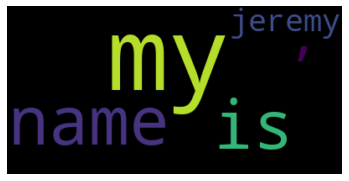

In [108]:
# -*- coding: utf-8 -*-
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
# wordcloud = WordCloud().generate(eng_news)


text = "hello , my name is jeremy i love to cooking jeremy is my first name , my last name is hsieh"
wordcloud = WordCloud(max_words = 5).generate_from_frequencies(Counter(text.split(' ')))
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")